In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings

# Ignore warnings for clean output
warnings.filterwarnings('ignore')

# Matplotlib settings
%matplotlib inline
sns.set(style="whitegrid")


Loading Raw data ```data.csv``` data

In [2]:
df = pd.read_csv('data/raw/data.csv')
df.head()

,Patient ID,Age,Gender,Blood Pressure,Heart Rate,Temperature,Oxygen Saturation,Respiratory Rate,Symptoms,Medical History,Diagnosis,Admission Date
0,1,82,Male,127/80,56.0,33.6,100,20,Headache,Stroke,Hypertension,2023-05-06
1,2,58,Other,121/83,NaN,37.5,99,12,Fatigue,NaN,Healthy,2023-01-04
2,3,59,Other,121/85,78.0,36.5,90,15,Cough,COVID-19,Asthma,2023-10-10
3,4,21,Female,145/96,89.0,37.0,97,20,Chest Pain,Hypertension,Stroke,2023-05-17
4,5,30,Male,128/78,69.0,37.4,90,15,Chest Pain,COVID-19,Hypertension,2023-02-03


### Preprocessing
- feature engineering

In [3]:
# Splitting Blood Pressure into two separate columns: Systolic and Diastolic
df[['Systolic BP', 'Diastolic BP']] = df['Blood Pressure'].str.split('/', expand=True)

# Convert Systolic and Diastolic BP to numeric
df['Systolic BP'] = pd.to_numeric(df['Systolic BP'], errors='coerce')
df['Diastolic BP'] = pd.to_numeric(df['Diastolic BP'], errors='coerce')

# Dropping the old 'Blood Pressure' column
df = df.drop('Blood Pressure', axis=1)

# Converting 'Admission Date' to datetime
df['Admission Date'] = pd.to_datetime(df['Admission Date'])

# One-Hot Encoding for 'Gender' and 'Symptoms'
df = pd.get_dummies(df, columns=['Gender', 'Symptoms' ,'Medical History' ,'Diagnosis' ], drop_first=True)

# Show the modified DataFrame
df.head()

,Patient ID,Age,Heart Rate,Temperature,Oxygen Saturation,Respiratory Rate,Admission Date,Systolic BP,Diastolic BP,Gender_Male,...,Medical History_Diabetes,Medical History_Heart Disease,Medical History_Hypertension,Medical History_Stroke,Diagnosis_COVID-19,Diagnosis_Diabetes,Diagnosis_Flu,Diagnosis_Healthy,Diagnosis_Hypertension,Diagnosis_Stroke
0,1,82,56.0,33.6,100,20,2023-05-06,127,80,True,...,False,False,False,True,False,False,False,False,True,False
1,2,58,NaN,37.5,99,12,2023-01-04,121,83,False,...,False,False,False,False,False,False,False,True,False,False
2,3,59,78.0,36.5,90,15,2023-10-10,121,85,False,...,False,False,False,False,False,False,False,False,False,False
3,4,21,89.0,37.0,97,20,2023-05-17,145,96,False,...,False,False,True,False,False,False,False,False,False,True
4,5,30,69.0,37.4,90,15,2023-02-03,128,78,True,...,False,False,False,False,False,False,False,False,True,False


### **Plotting**
 - The preprocessed data

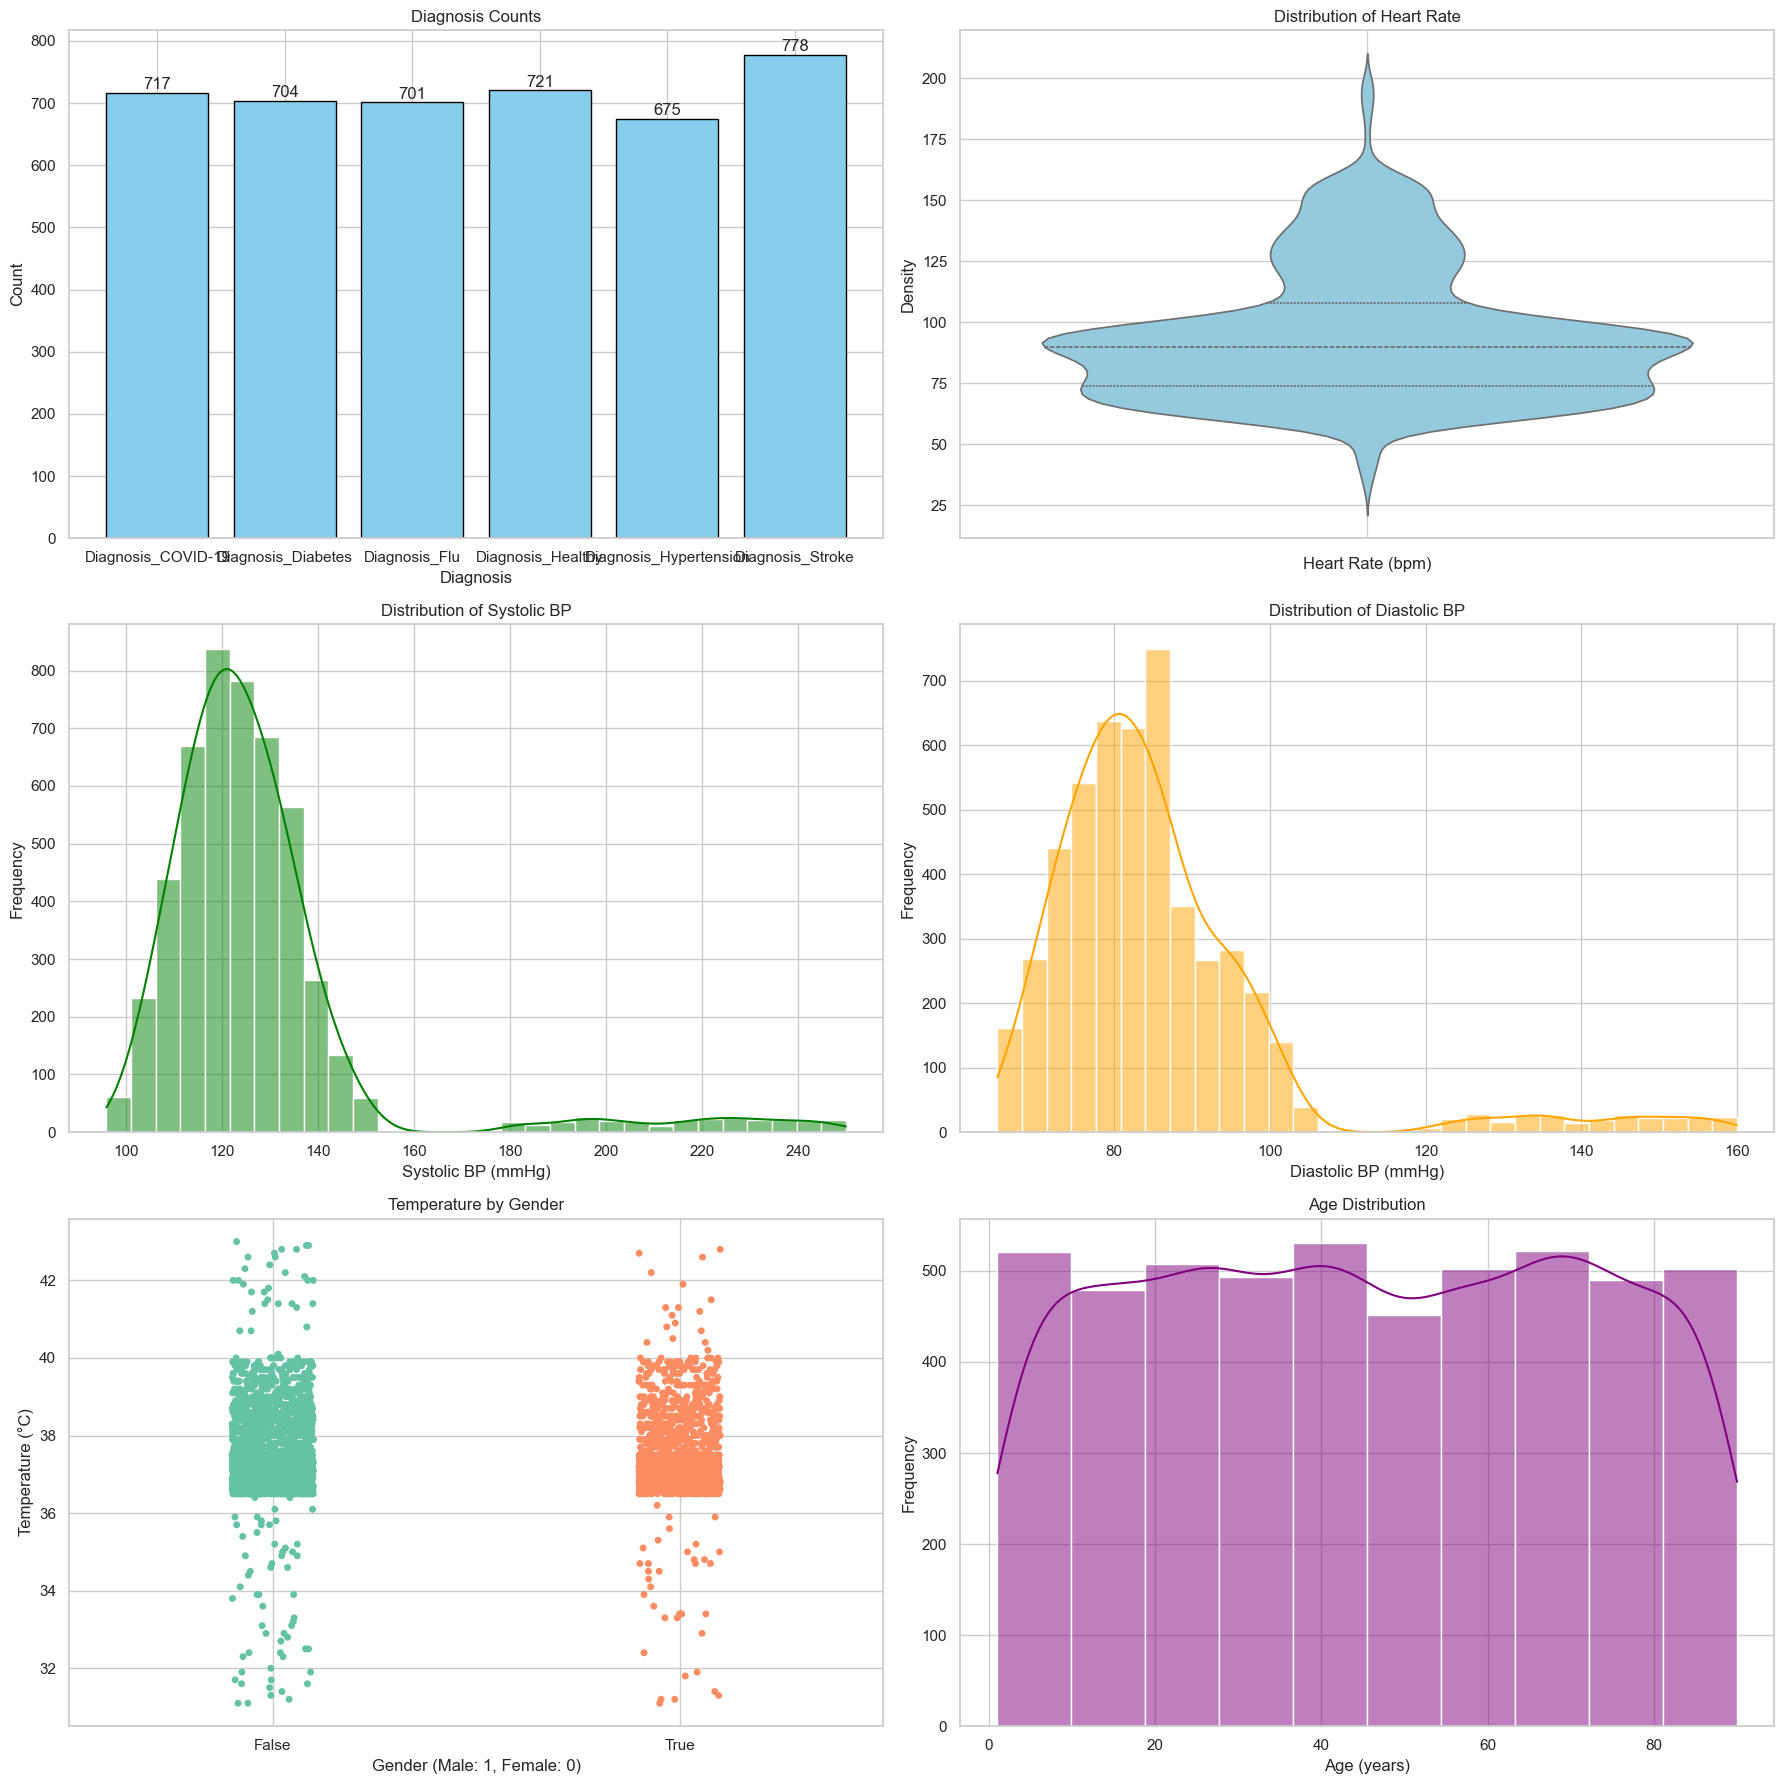

In [4]:
# Create a copy of the original DataFrame to preserve it
df_copy = df.copy()

df_copy['Admission Date'] = pd.to_datetime(df_copy['Admission Date'])
df_copy = df_copy.sort_values('Admission Date')

fig, axs = plt.subplots(3, 2, figsize=(18, 18))

# Diagnosis Counts Bar Plot
diagnosis_columns = ['Diagnosis_COVID-19', 'Diagnosis_Diabetes', 'Diagnosis_Flu', 'Diagnosis_Healthy', 'Diagnosis_Hypertension', 'Diagnosis_Stroke']
diagnosis_counts = df_copy[diagnosis_columns].sum()

bars = axs[0, 0].bar(diagnosis_counts.index, diagnosis_counts.values, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Diagnosis Counts')
axs[0, 0].set_xlabel('Diagnosis')
axs[0, 0].set_ylabel('Count')
axs[0, 0].grid(True)
for bar in bars:
    yval = bar.get_height()
    axs[0, 0].text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

# Heart Rate Violin Plot
sns.violinplot(y='Heart Rate', data=df_copy, ax=axs[0, 1], inner='quartile', color='skyblue')
axs[0, 1].set_title('Distribution of Heart Rate')
axs[0, 1].set_xlabel('Heart Rate (bpm)')
axs[0, 1].set_ylabel('Density')
axs[0, 1].grid(True)

# Systolic BP Histogram
sns.histplot(df_copy['Systolic BP'].dropna(), bins=30, kde=True, ax=axs[1, 0], color='green')
axs[1, 0].set_title('Distribution of Systolic BP')
axs[1, 0].set_xlabel('Systolic BP (mmHg)')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].grid(True)

# Diastolic BP Histogram
sns.histplot(df_copy['Diastolic BP'].dropna(), bins=30, kde=True, ax=axs[1, 1], color='orange')
axs[1, 1].set_title('Distribution of Diastolic BP')
axs[1, 1].set_xlabel('Diastolic BP (mmHg)')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].grid(True)

# Temperature by Gender Plot
sns.stripplot(x='Gender_Male', y='Temperature', data=df_copy, ax=axs[2, 0], jitter=True, palette='Set2')
axs[2, 0].set_title('Temperature by Gender')
axs[2, 0].set_xlabel('Gender (Male: 1, Female: 0)')
axs[2, 0].set_ylabel('Temperature (°C)')
axs[2, 0].grid(True)

# Age Distribution Histogram
sns.histplot(df_copy['Age'], bins=10, kde=True, ax=axs[2, 1], color='purple')
axs[2, 1].set_title('Age Distribution')
axs[2, 1].set_xlabel('Age (years)')
axs[2, 1].set_ylabel('Frequency')
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()


plot ka section khatam

In [5]:
# Show the modified DataFrame
df.head()

,Patient ID,Age,Heart Rate,Temperature,Oxygen Saturation,Respiratory Rate,Admission Date,Systolic BP,Diastolic BP,Gender_Male,...,Medical History_Diabetes,Medical History_Heart Disease,Medical History_Hypertension,Medical History_Stroke,Diagnosis_COVID-19,Diagnosis_Diabetes,Diagnosis_Flu,Diagnosis_Healthy,Diagnosis_Hypertension,Diagnosis_Stroke
0,1,82,56.0,33.6,100,20,2023-05-06,127,80,True,...,False,False,False,True,False,False,False,False,True,False
1,2,58,NaN,37.5,99,12,2023-01-04,121,83,False,...,False,False,False,False,False,False,False,True,False,False
2,3,59,78.0,36.5,90,15,2023-10-10,121,85,False,...,False,False,False,False,False,False,False,False,False,False
3,4,21,89.0,37.0,97,20,2023-05-17,145,96,False,...,False,False,True,False,False,False,False,False,False,True
4,5,30,69.0,37.4,90,15,2023-02-03,128,78,True,...,False,False,False,False,False,False,False,False,True,False


### **Adding Emergency column**

In [6]:
# Function to classify emergency levels based on medical research
def classify_emergency(row):
    # Initialize emergency score
    emergency_score = 0
    
    # Blood Pressure (BP) based on ACC/AHA and ESC guidelines
    if row['Systolic BP'] >= 180 or row['Diastolic BP'] >= 120:
        emergency_score += 4  # Hypertensive crisis
    elif 160 <= row['Systolic BP'] < 180 or 100 <= row['Diastolic BP'] < 120:
        emergency_score += 3  # Severe Hypertension
    elif 140 <= row['Systolic BP'] < 160 or 90 <= row['Diastolic BP'] < 100:
        emergency_score += 2  # Hypertension Stage 2
    elif 130 <= row['Systolic BP'] < 140 or 80 <= row['Diastolic BP'] < 90:
        emergency_score += 1  # Hypertension Stage 1
    else:
        emergency_score += 0  # Normal BP
    
    # Heart Rate (HR) based on clinical guidelines
    if row['Heart Rate'] > 130:
        emergency_score += 3  # Severe Tachycardia
    elif 100 < row['Heart Rate'] <= 130:
        emergency_score += 2  # Moderate Tachycardia
    elif 60 < row['Heart Rate'] <= 100:
        emergency_score += 1  # Normal
    elif 40 <= row['Heart Rate'] < 60:
        emergency_score += 2  # Mild Bradycardia
    else:
        emergency_score += 4  # Severe Bradycardia
    
    # Temperature (Temp) based on IDSA and WHO guidelines
    if row['Temperature'] < 34.0:
        emergency_score += 4  # Severe Hypothermia
    elif 34.0 <= row['Temperature'] < 35.0:
        emergency_score += 3  # Hypothermia
    elif row['Temperature'] > 38.5:
        emergency_score += 2  # Severe Fever
    elif 37.5 < row['Temperature'] <= 38.5:
        emergency_score += 1  # Fever
    else:
        emergency_score += 0  # Normal Temp
    
    # Respiratory Rate (RR) based on ARDS and Sepsis definitions
    if row['Respiratory Rate'] > 30:
        emergency_score += 4  # Severe Respiratory Distress
    elif 24 < row['Respiratory Rate'] <= 30:
        emergency_score += 3  # Moderate Respiratory Distress
    elif 16 < row['Respiratory Rate'] <= 24:
        emergency_score += 2  # Mild Respiratory Distress
    elif 12 <= row['Respiratory Rate'] <= 16:
        emergency_score += 1  # Normal RR
    else:
        emergency_score += 4  # Respiratory Failure
    
    # Oxygen Saturation (SpO2) based on WHO and ATS guidelines
    if row['Oxygen Saturation'] < 85:
        emergency_score += 4  # Severe Hypoxemia
    elif 85 <= row['Oxygen Saturation'] < 90:
        emergency_score += 3  # Moderate Hypoxemia
    elif 90 <= row['Oxygen Saturation'] < 94:
        emergency_score += 2  # Mild Hypoxemia
    else:
        emergency_score += 0  # Normal Oxygen Saturation
    
    # Return emergency level based on the total emergency score
    if emergency_score >= 12:
        return 'Very Critical'
    elif 8 <= emergency_score < 12:
        return 'High'
    elif 4 <= emergency_score < 8:
        return 'Medium'
    else:
        return 'Low'

# Applying the function to classify emergency levels
df['Emergency_Level'] = df.apply(classify_emergency, axis=1)

# Convert Emergency_Level to numerical for the ML model
df['Emergency_Level'] = df['Emergency_Level'].map({'Low': 0, 'Medium': 1, 'High': 2, 'Very Critical': 3})

# Display the updated DataFrame with emergency levels
df.head(5)


,Patient ID,Age,Heart Rate,Temperature,Oxygen Saturation,Respiratory Rate,Admission Date,Systolic BP,Diastolic BP,Gender_Male,...,Medical History_Heart Disease,Medical History_Hypertension,Medical History_Stroke,Diagnosis_COVID-19,Diagnosis_Diabetes,Diagnosis_Flu,Diagnosis_Healthy,Diagnosis_Hypertension,Diagnosis_Stroke,Emergency_Level
0,1,82,56.0,33.6,100,20,2023-05-06,127,80,True,...,False,False,True,False,False,False,False,True,False,2
1,2,58,NaN,37.5,99,12,2023-01-04,121,83,False,...,False,False,False,False,False,False,True,False,False,1
2,3,59,78.0,36.5,90,15,2023-10-10,121,85,False,...,False,False,False,False,False,False,False,False,False,1
3,4,21,89.0,37.0,97,20,2023-05-17,145,96,False,...,False,True,False,False,False,False,False,False,True,1
4,5,30,69.0,37.4,90,15,2023-02-03,128,78,True,...,False,False,False,False,False,False,False,True,False,1


 Checking class distribution

In [7]:
print(df['Emergency_Level'].value_counts())
df.head()

Emergency_Level
1    2786
2    1253
0     853
3     108
Name: count, dtype: int64


,Patient ID,Age,Heart Rate,Temperature,Oxygen Saturation,Respiratory Rate,Admission Date,Systolic BP,Diastolic BP,Gender_Male,...,Medical History_Heart Disease,Medical History_Hypertension,Medical History_Stroke,Diagnosis_COVID-19,Diagnosis_Diabetes,Diagnosis_Flu,Diagnosis_Healthy,Diagnosis_Hypertension,Diagnosis_Stroke,Emergency_Level
0,1,82,56.0,33.6,100,20,2023-05-06,127,80,True,...,False,False,True,False,False,False,False,True,False,2
1,2,58,NaN,37.5,99,12,2023-01-04,121,83,False,...,False,False,False,False,False,False,True,False,False,1
2,3,59,78.0,36.5,90,15,2023-10-10,121,85,False,...,False,False,False,False,False,False,False,False,False,1
3,4,21,89.0,37.0,97,20,2023-05-17,145,96,False,...,False,True,False,False,False,False,False,False,True,1
4,5,30,69.0,37.4,90,15,2023-02-03,128,78,True,...,False,False,False,False,False,False,False,True,False,1


### ⚡ Normalizing the dataset

In [8]:
# Import StandardScaler for normalization
from sklearn.preprocessing import StandardScaler

# Selecting numeric columns to normalize
numeric_cols = ['Age', 'Systolic BP', 'Diastolic BP', 'Heart Rate', 'Temperature', 'Respiratory Rate']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numeric columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Display the normalized dataframe
df.head()


,Patient ID,Age,Heart Rate,Temperature,Oxygen Saturation,Respiratory Rate,Admission Date,Systolic BP,Diastolic BP,Gender_Male,...,Medical History_Heart Disease,Medical History_Hypertension,Medical History_Stroke,Diagnosis_COVID-19,Diagnosis_Diabetes,Diagnosis_Flu,Diagnosis_Healthy,Diagnosis_Hypertension,Diagnosis_Stroke,Emergency_Level
0,1,1.404628,-1.410492,-3.574141,100,0.689224,2023-05-06,-0.036343,-0.372975,True,...,False,False,True,False,False,False,False,True,False,2
1,2,0.482860,NaN,0.114599,99,-1.049484,2023-01-04,-0.285322,-0.184324,False,...,False,False,False,False,False,False,True,False,False,1
2,3,0.521267,-0.606656,-0.831232,90,-0.397469,2023-10-10,-0.285322,-0.058557,False,...,False,False,False,False,False,False,False,False,False,1
3,4,-0.938198,-0.204738,-0.358316,97,0.689224,2023-05-17,0.710596,0.633162,False,...,False,True,False,False,False,False,False,False,True,1
4,5,-0.592535,-0.935498,0.020016,90,-0.397469,2023-02-03,0.005154,-0.498742,True,...,False,False,False,False,False,False,False,True,False,1


saving the pre-processed data to ```preprocessed.csv```

In [9]:
print("Columns in DataFrame:")
print(df.columns)

df.to_csv('data/preprocessed/preprocessed.csv' ,index= False)
print("Saved to CSV  file named : preprocessed.csv")
df.head()

Columns in DataFrame:
Index(['Patient ID', 'Age', 'Heart Rate', 'Temperature', 'Oxygen Saturation',
       'Respiratory Rate', 'Admission Date', 'Systolic BP', 'Diastolic BP',
       'Gender_Male', 'Gender_Other', 'Symptoms_Cough', 'Symptoms_Fatigue',
       'Symptoms_Fever', 'Symptoms_Headache', 'Symptoms_Nausea',
       'Symptoms_Shortness of Breath', 'Medical History_COVID-19',
       'Medical History_Diabetes', 'Medical History_Heart Disease',
       'Medical History_Hypertension', 'Medical History_Stroke',
       'Diagnosis_COVID-19', 'Diagnosis_Diabetes', 'Diagnosis_Flu',
       'Diagnosis_Healthy', 'Diagnosis_Hypertension', 'Diagnosis_Stroke',
       'Emergency_Level'],
      dtype='object')
Saved to CSV  file named : preprocessed.csv


,Patient ID,Age,Heart Rate,Temperature,Oxygen Saturation,Respiratory Rate,Admission Date,Systolic BP,Diastolic BP,Gender_Male,...,Medical History_Heart Disease,Medical History_Hypertension,Medical History_Stroke,Diagnosis_COVID-19,Diagnosis_Diabetes,Diagnosis_Flu,Diagnosis_Healthy,Diagnosis_Hypertension,Diagnosis_Stroke,Emergency_Level
0,1,1.404628,-1.410492,-3.574141,100,0.689224,2023-05-06,-0.036343,-0.372975,True,...,False,False,True,False,False,False,False,True,False,2
1,2,0.482860,NaN,0.114599,99,-1.049484,2023-01-04,-0.285322,-0.184324,False,...,False,False,False,False,False,False,True,False,False,1
2,3,0.521267,-0.606656,-0.831232,90,-0.397469,2023-10-10,-0.285322,-0.058557,False,...,False,False,False,False,False,False,False,False,False,1
3,4,-0.938198,-0.204738,-0.358316,97,0.689224,2023-05-17,0.710596,0.633162,False,...,False,True,False,False,False,False,False,False,True,1
4,5,-0.592535,-0.935498,0.020016,90,-0.397469,2023-02-03,0.005154,-0.498742,True,...,False,False,False,False,False,False,False,True,False,1


### **Plotting**
 - The preprocessed and normalized data

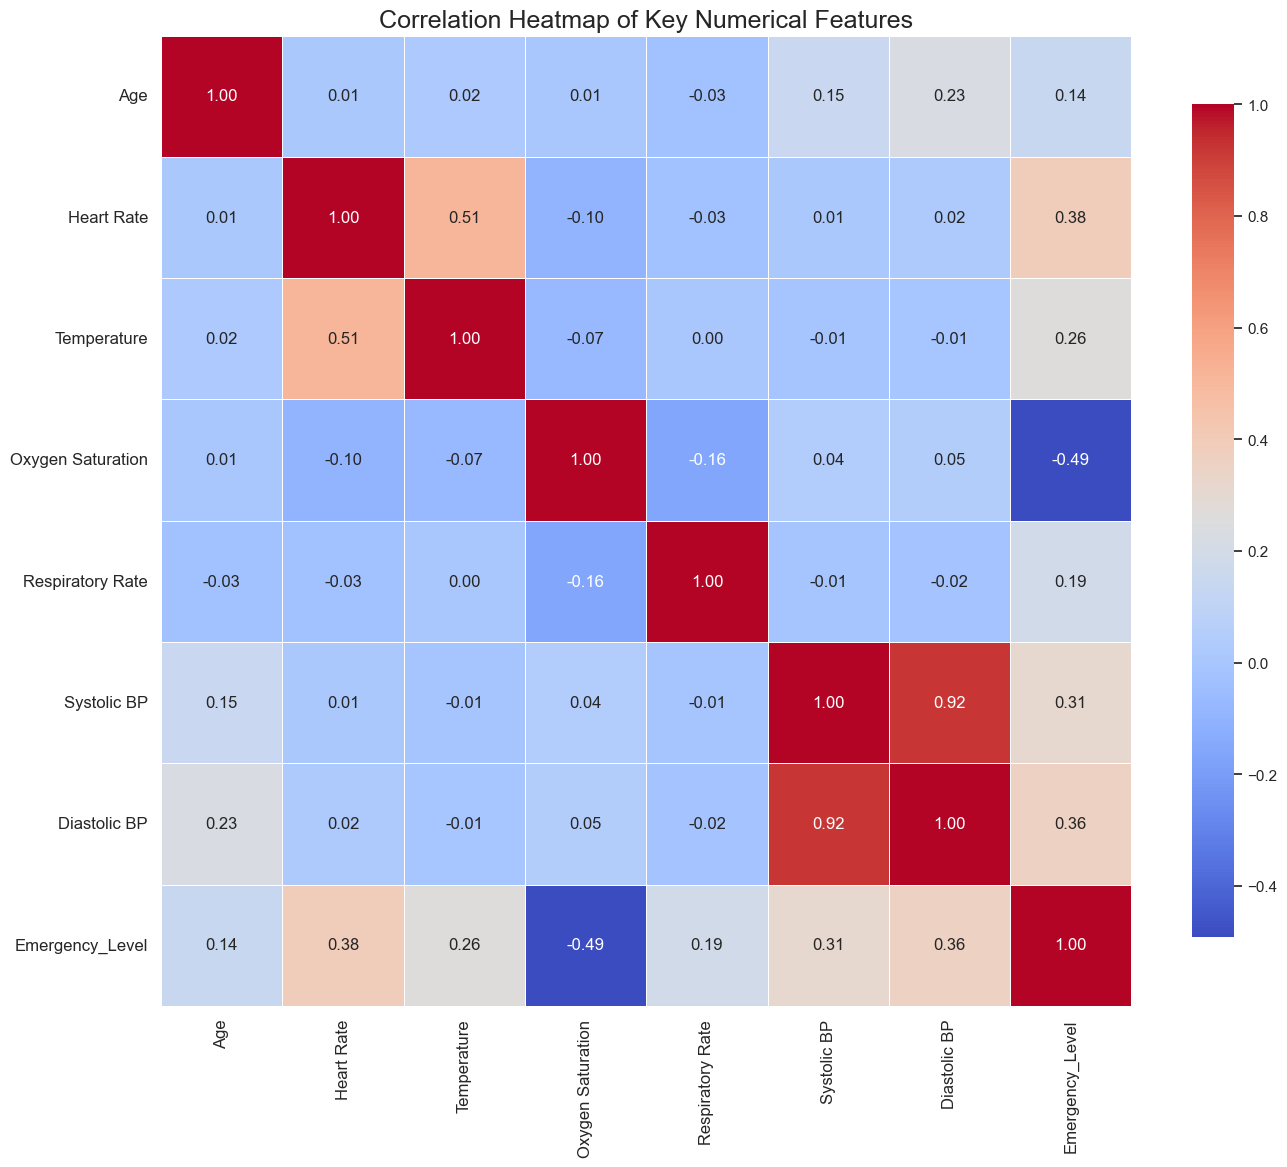

<Figure size 2000x1600 with 0 Axes>

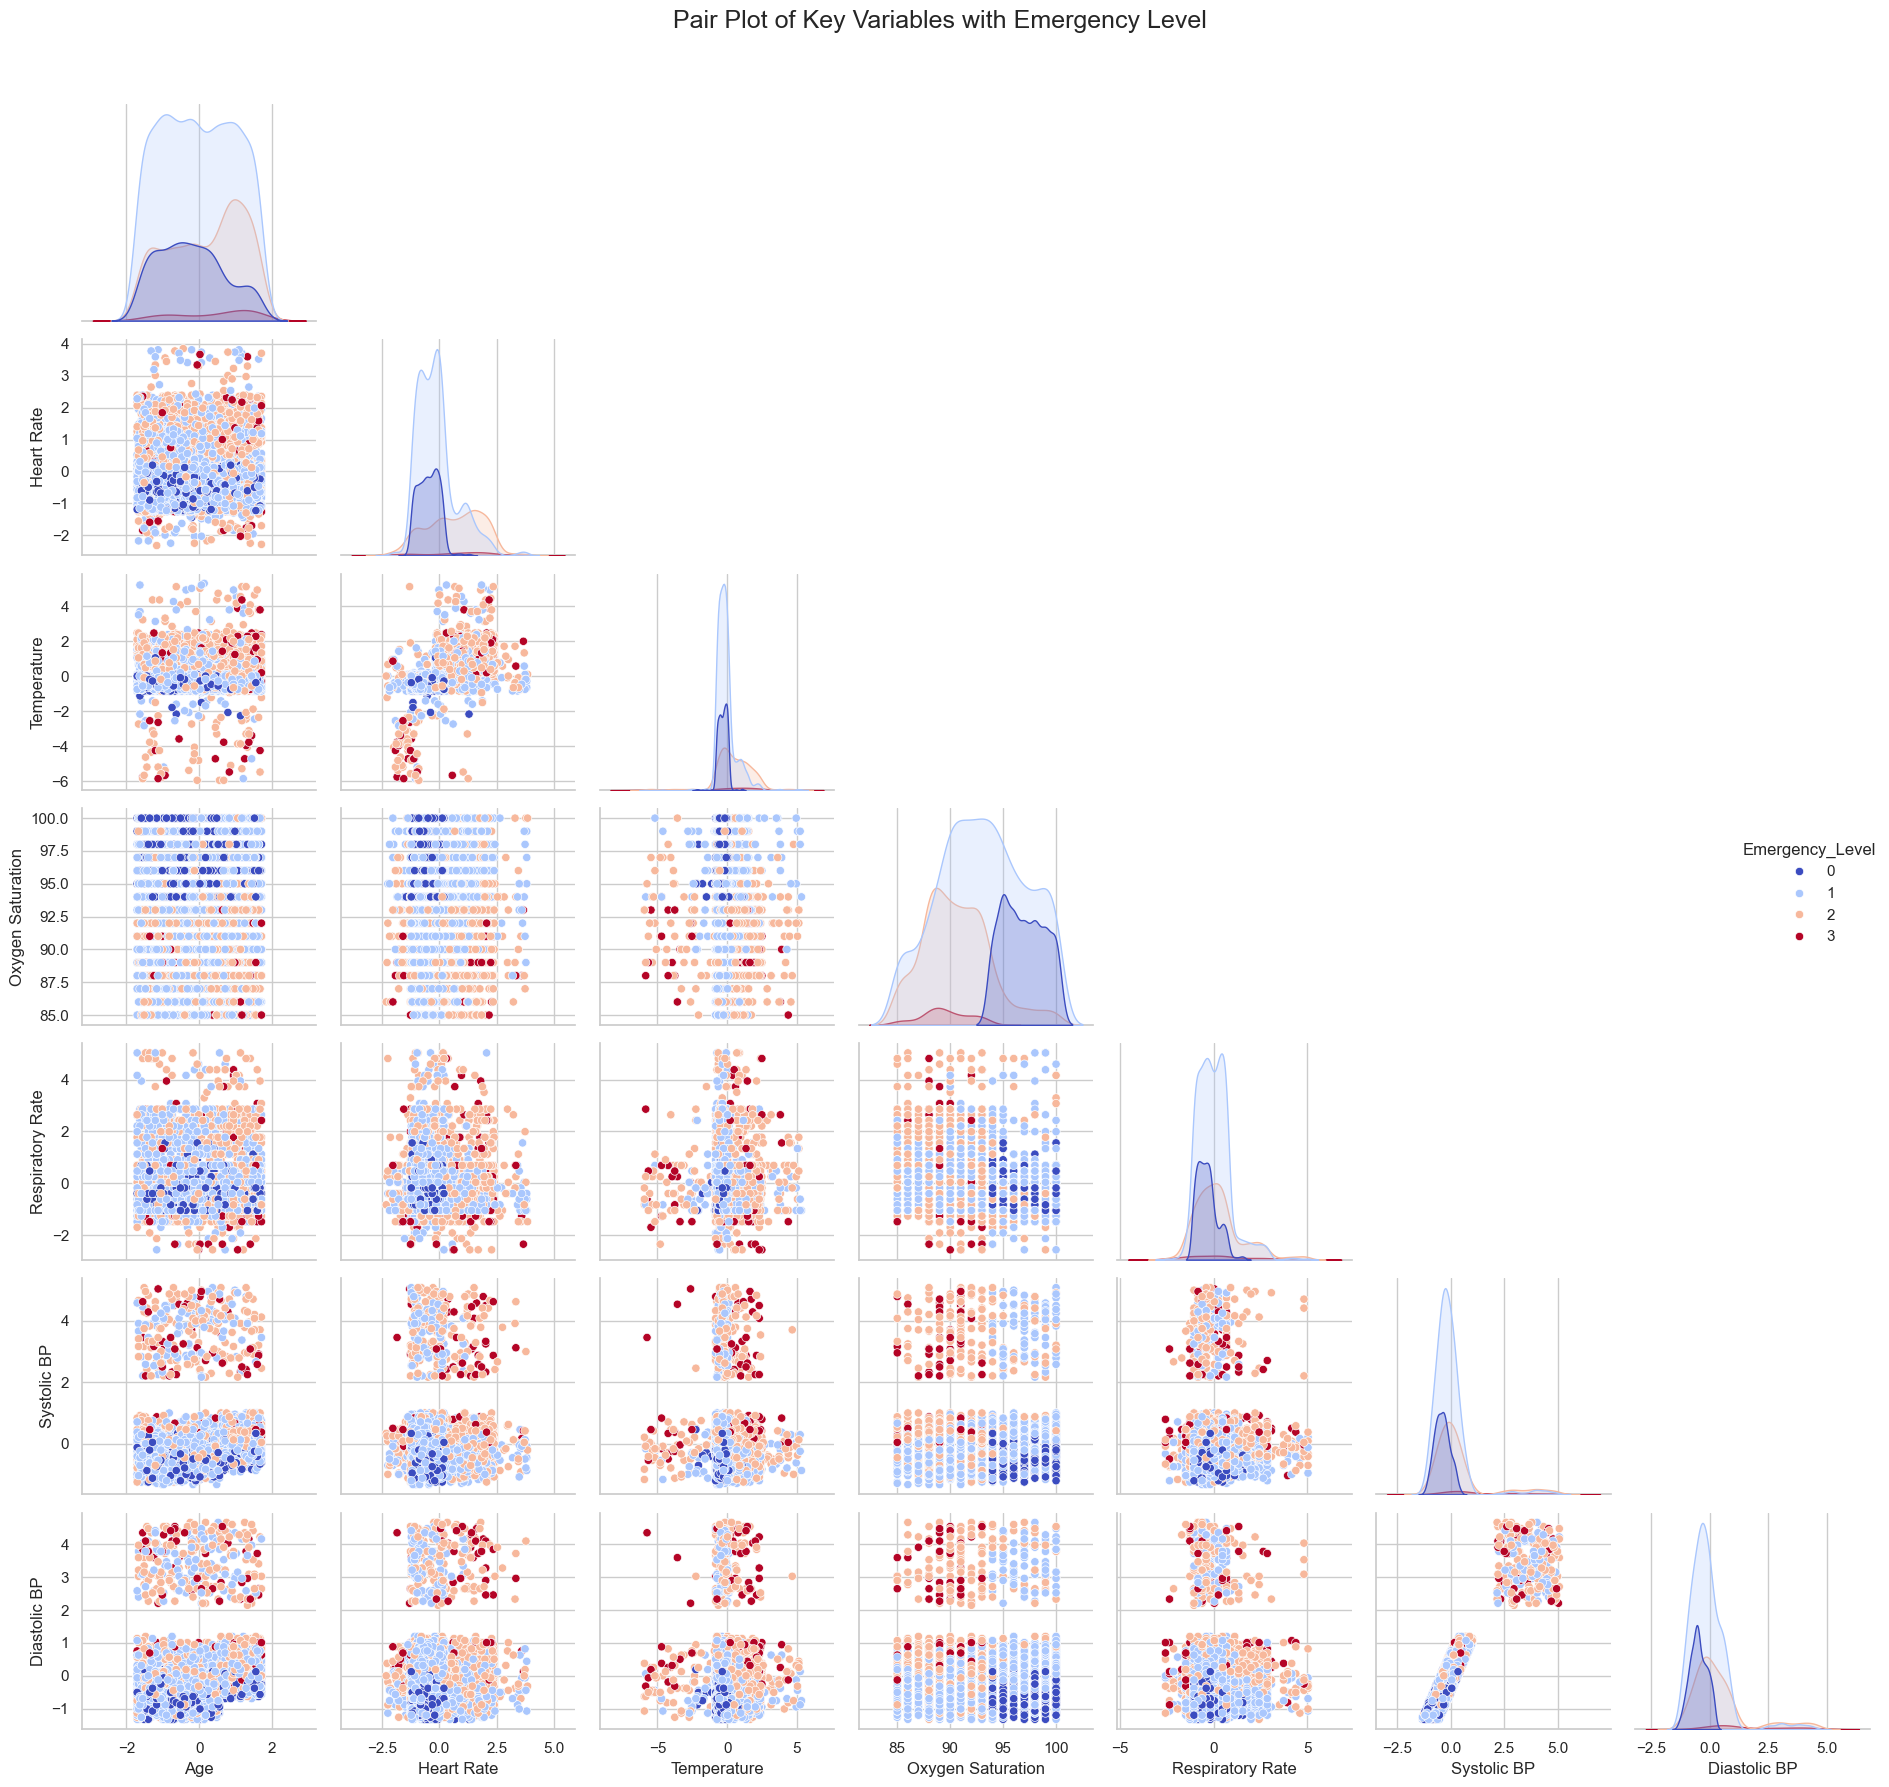

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Creating a copy to preserve the original DataFrame
df_copy = df.copy()

# Converting 'Admission Date' to datetime
df_copy['Admission Date'] = pd.to_datetime(df_copy['Admission Date'])
df_copy = df_copy.sort_values('Admission Date')

# Selecting numerical columns for the heatmap, excluding non-numerical or irrelevant ones
numerical_cols = ['Age', 'Heart Rate', 'Temperature', 'Oxygen Saturation', 'Respiratory Rate', 'Systolic BP', 'Diastolic BP', 'Emergency_Level']

# Calculating the correlation matrix
corr_matrix = df_copy[numerical_cols].corr()

# Creating the heatmap with larger figure size
plt.figure(figsize=(14, 12))  # Increased figure size for better visibility
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True, cbar_kws={"shrink": 0.8}, annot_kws={"size": 12})
plt.title('Correlation Heatmap of Key Numerical Features', fontsize=18)  # Increased title font size
plt.xticks(fontsize=12)  # Increased x-axis tick size
plt.yticks(fontsize=12)  # Increased y-axis tick size
plt.tight_layout()
plt.show()

# Selecting key variables for the pair plot
key_vars = ['Age', 'Heart Rate', 'Temperature', 'Oxygen Saturation', 'Respiratory Rate', 'Systolic BP', 'Diastolic BP', 'Emergency_Level']

# Creating the pair plot with larger figure size
plt.figure(figsize=(20, 16))  # Larger figure size for the pair plot
sns.pairplot(df_copy[key_vars], hue='Emergency_Level', palette='coolwarm', diag_kind='kde', corner=True, height=2.5)
plt.suptitle('Pair Plot of Key Variables with Emergency Level', y=1.02, fontsize=18)  # Increased title font size
plt.tight_layout()
plt.show()


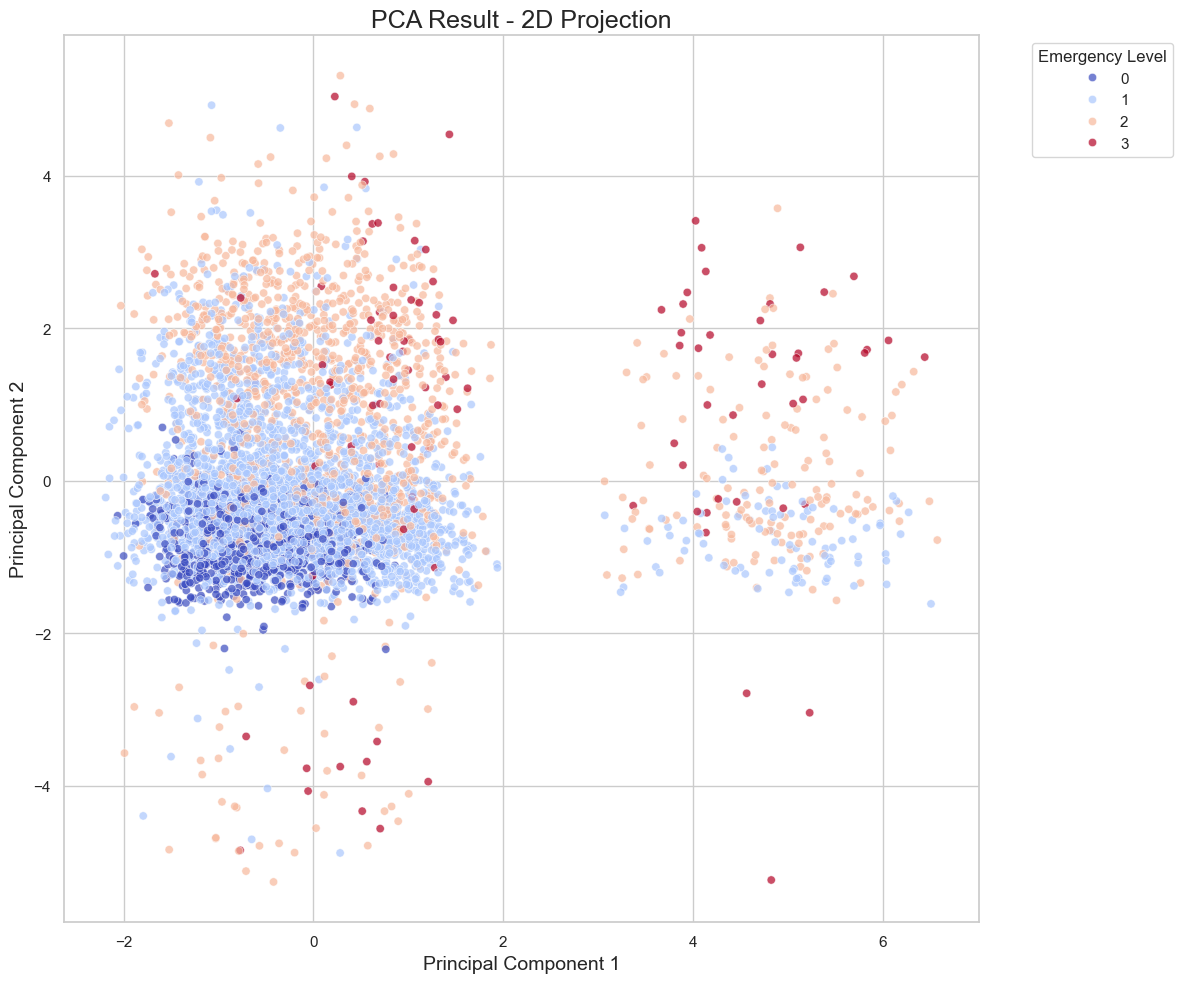

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Creating a copy to preserve the original DataFrame
df_copy = df.copy()

# Converting 'Admission Date' to datetime
df_copy['Admission Date'] = pd.to_datetime(df_copy['Admission Date'])
df_copy = df_copy.sort_values('Admission Date')

# Selecting numerical columns for PCA
numerical_cols = ['Age', 'Heart Rate', 'Temperature', 'Oxygen Saturation', 'Respiratory Rate', 'Systolic BP', 'Diastolic BP']

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
imputed_data = imputer.fit_transform(df_copy[numerical_cols])

# Standardizing the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed_data)

# Performing PCA
pca = PCA(n_components=2)  # Reduce to 2 components for 2D visualization
pca_result = pca.fit_transform(scaled_data)

# Creating a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Emergency_Level'] = df_copy['Emergency_Level'].values

# Plotting the PCA results
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='Emergency_Level', data=pca_df, palette='coolwarm', alpha=0.7)
plt.title('PCA Result - 2D Projection', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Emergency Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [12]:
pca_result

array([[ 0.88064757,  0.97897772],
       [-0.29685099, -0.55730518],
       [-0.73294914,  2.34099248],
       ...,
       [ 0.63674492,  2.36756902],
       [-1.24669103, -0.67820664],
       [ 0.71901271, -1.12130648]])

In [13]:
df.head()

,Patient ID,Age,Heart Rate,Temperature,Oxygen Saturation,Respiratory Rate,Admission Date,Systolic BP,Diastolic BP,Gender_Male,...,Medical History_Heart Disease,Medical History_Hypertension,Medical History_Stroke,Diagnosis_COVID-19,Diagnosis_Diabetes,Diagnosis_Flu,Diagnosis_Healthy,Diagnosis_Hypertension,Diagnosis_Stroke,Emergency_Level
0,1,1.404628,-1.410492,-3.574141,100,0.689224,2023-05-06,-0.036343,-0.372975,True,...,False,False,True,False,False,False,False,True,False,2
1,2,0.482860,NaN,0.114599,99,-1.049484,2023-01-04,-0.285322,-0.184324,False,...,False,False,False,False,False,False,True,False,False,1
2,3,0.521267,-0.606656,-0.831232,90,-0.397469,2023-10-10,-0.285322,-0.058557,False,...,False,False,False,False,False,False,False,False,False,1
3,4,-0.938198,-0.204738,-0.358316,97,0.689224,2023-05-17,0.710596,0.633162,False,...,False,True,False,False,False,False,False,False,True,1
4,5,-0.592535,-0.935498,0.020016,90,-0.397469,2023-02-03,0.005154,-0.498742,True,...,False,False,False,False,False,False,False,True,False,1


plotting khatam

## **Emergency Score Generation**

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# Load the dataset
df = pd.read_csv('data/preprocessed/preprocessed.csv')

# Drop rows with missing values
df.dropna(inplace=True)

# Prepare the features and target
X = df.drop(columns=['Patient ID', 'Emergency_Level', 'Admission Date'])
y = df['Emergency_Level']

# Convert boolean columns to integers
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Normalize the feature data using StandardScaler to bring all features to the same scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict probabilities for the test set (continuous score)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]  # Probability for emergency level 1 (positive class)

# Evaluate the model accuracy and F1 score
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Check if the model's accuracy meets the 85% threshold
if accuracy < 0.85:
    print(f"Warning: Model accuracy is below 85%. Current accuracy: {accuracy * 100:.2f}%")
else:
    print(f"Model accuracy is satisfactory: {accuracy * 100:.2f}%")

# Add the continuous emergency score to the original dataset
df['Emergency Score'] = log_reg.predict_proba(scaler.transform(X))[:, 1]

# Display the updated dataset
print(df[['Patient ID', 'Emergency Score']])
df.head(10)

# Save the updated DataFrame to the CSV file
df.to_csv('data/preprocessed/preprocessed.csv', index=False)

df.head()

# Print column names to verify
print("\nColumns in processed_df:")
print(df.columns)


      Patient ID  Emergency Score
0              1         0.222903
2              3         0.875193
3              4         0.933173
4              5         0.924931
5              6         0.191435
...          ...              ...
4994        4995         0.174001
4995        4996         0.353075
4996        4997         0.668547
4998        4999         0.143075
4999        5000         0.802953

[4502 rows x 2 columns]

Columns in processed_df:
Index(['Patient ID', 'Age', 'Heart Rate', 'Temperature', 'Oxygen Saturation',
       'Respiratory Rate', 'Admission Date', 'Systolic BP', 'Diastolic BP',
       'Gender_Male', 'Gender_Other', 'Symptoms_Cough', 'Symptoms_Fatigue',
       'Symptoms_Fever', 'Symptoms_Headache', 'Symptoms_Nausea',
       'Symptoms_Shortness of Breath', 'Medical History_COVID-19',
       'Medical History_Diabetes', 'Medical History_Heart Disease',
       'Medical History_Hypertension', 'Medical History_Stroke',
       'Diagnosis_COVID-19', 'Diagnosis_Diabet

### *Creating a New File ```training.csv``` with raw data and emergency score mapping*

In [15]:
import pandas as pd

# Load the data
data_df = pd.read_csv('data/raw/data.csv')
processed_df = pd.read_csv('data/preprocessed/preprocessed.csv')

# Select the necessary columns from processed.csv (Patient ID, Systolic BP, Diastolic BP, Emergency Score)
processed_df = processed_df[['Patient ID', 'Systolic BP', 'Diastolic BP', 'Emergency Score']]

# Merge both dataframes on 'Patient ID'
merged_df = pd.merge(data_df, processed_df, on='Patient ID', how='left')

# Drop the 'Blood Pressure' column from the merged dataframe
merged_df = merged_df.drop('Blood Pressure', axis=1)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('data/processed/training.csv', index=False)

print("Merged CSV files as : 'training.csv' \nRemoved 'Blood Pressure' column")


Merged CSV files as : 'training.csv' 
Removed 'Blood Pressure' column


## **Model Training** 
for user data to emergency score prediction

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('data/processed/training.csv')

# Drop rows with missing values
df.dropna(inplace=True)

# Define features and target
X = df[['Patient ID', 'Age', 'Gender','Systolic BP','Diastolic BP', 'Heart Rate', 
        'Temperature', 'Oxygen Saturation', 'Respiratory Rate', 
        'Symptoms', 'Medical History', 'Diagnosis', 'Admission Date']]
y = df['Emergency Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical features
numerical_features = ['Age', 'Heart Rate','Systolic BP','Diastolic BP', 'Temperature', 'Oxygen Saturation', 'Respiratory Rate']
categorical_features = ['Gender', 'Symptoms', 'Medical History', 'Diagnosis']

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Create the pipeline with the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Check the model performance
print(f"Training accuracy: {model.score(X_train, y_train):.2f}")
print(f"Testing accuracy: {model.score(X_test, y_test):.2f}")


Training accuracy: 0.99
Testing accuracy: 0.90


### **Plotting**
 - The fit regression line

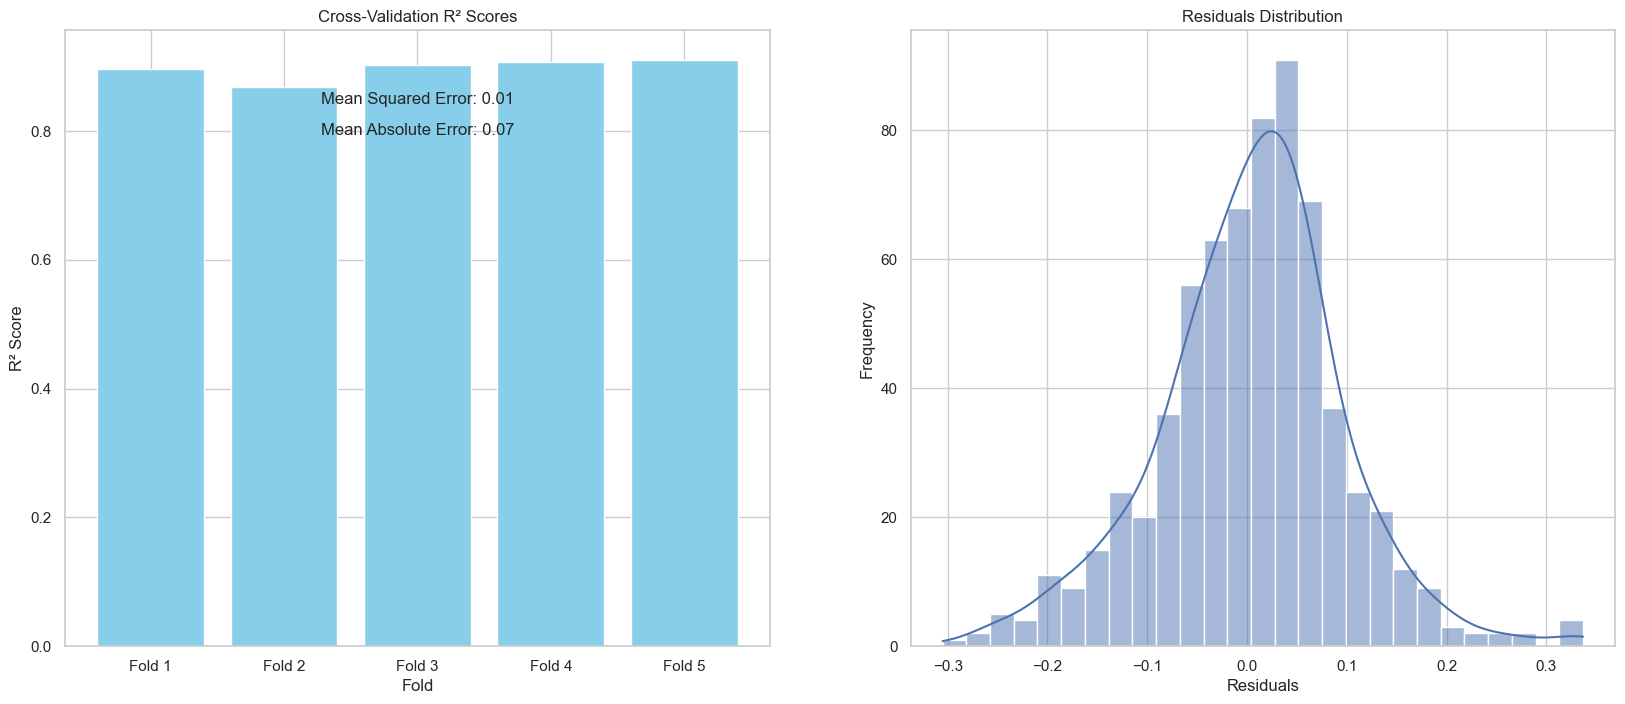

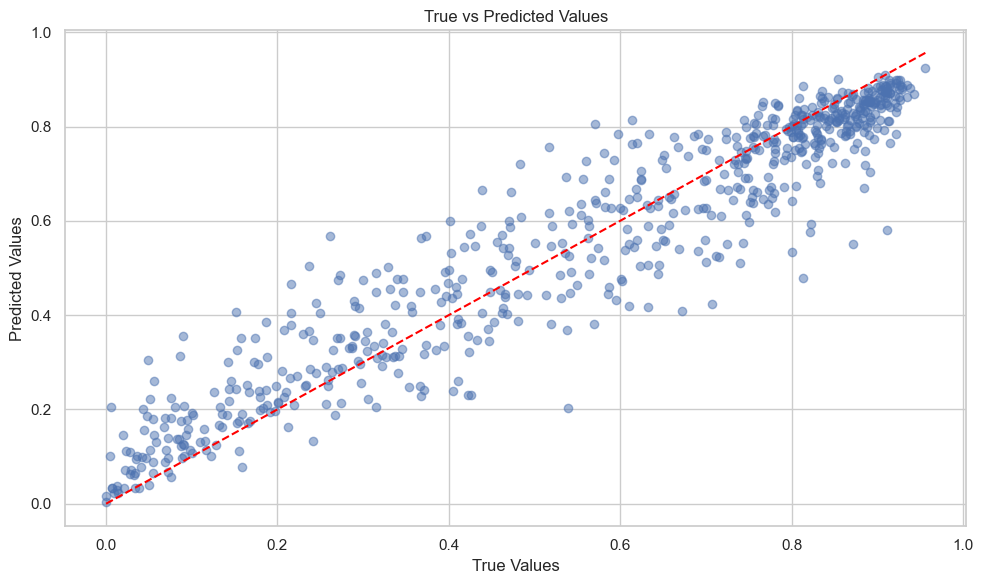

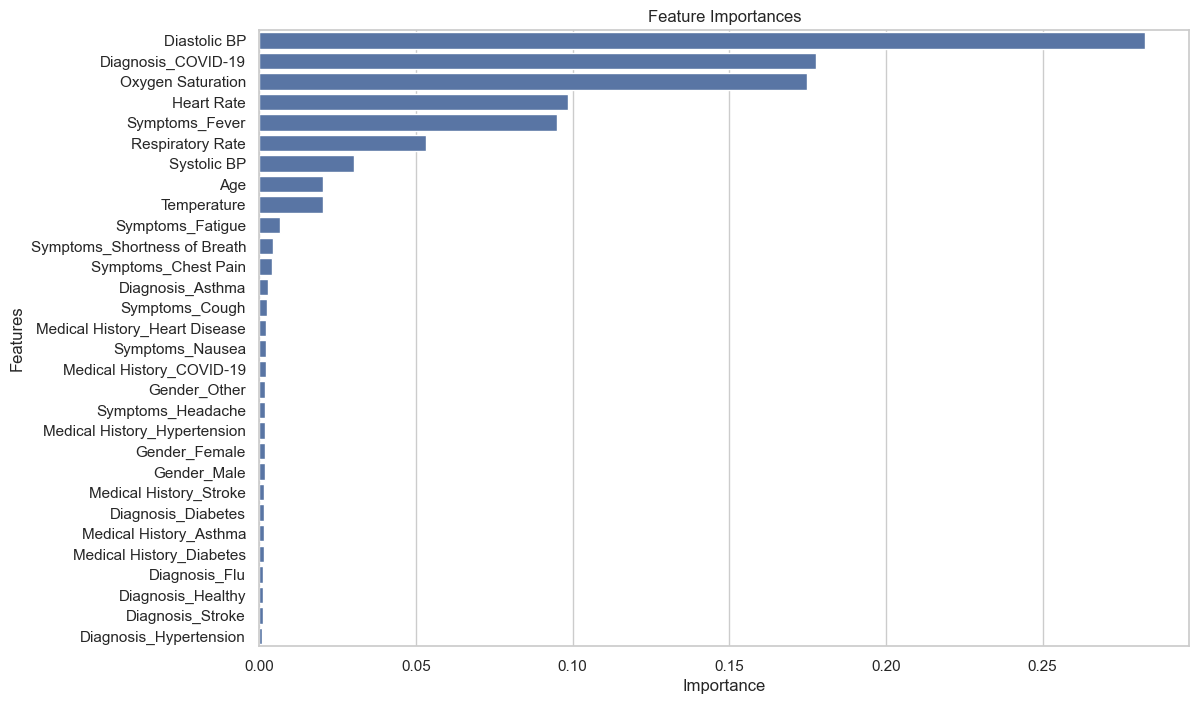

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

# Evaluate model using cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# Predict and evaluate performance on test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Model Performance Metrics
# Cross-validation R^2 scores as a bar plot
ax[0].bar(range(len(cv_scores)), cv_scores, color='skyblue')
ax[0].set_xticks(range(len(cv_scores)))
ax[0].set_xticklabels([f'Fold {i+1}' for i in range(len(cv_scores))])
ax[0].set_title('Cross-Validation R² Scores')
ax[0].set_xlabel('Fold')
ax[0].set_ylabel('R² Score')

# Adding MSE and MAE as text
ax[0].text(0.5, 0.9, f'Mean Squared Error: {mse:.2f}', ha='center', va='top', fontsize=12, transform=ax[0].transAxes)
ax[0].text(0.5, 0.85, f'Mean Absolute Error: {mae:.2f}', ha='center', va='top', fontsize=12, transform=ax[0].transAxes)

# Plot 2: Residuals and True vs Predicted Values
# Residuals distribution
residuals = y_test - y_pred
sns.histplot(residuals, kde=True, ax=ax[1])
ax[1].set_title('Residuals Distribution')
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Frequency')

# Scatter plot of true vs predicted values
plt.figure(figsize=(10, 6))
ax2 = plt.subplot(1, 1, 1)
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
ax2.set_xlabel('True Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title('True vs Predicted Values')

# Adjust layout
plt.tight_layout()
plt.show()




# Checking most influencial features in the model

# Extract feature importances
importances = model.named_steps['regressor'].feature_importances_
features = numerical_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())

# Create a DataFrame for easy plotting
feature_importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


## **Predection**
New Patien's emergency score generated by model

In [18]:
# New patient data
new_data = pd.DataFrame({
    'Patient ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Age': [49, 33, 7, 30, 14, 88, 73, 76, 40, 61],
    'Gender': ['Female', 'Other', 'Female', 'Male', 'Other', 'Male', 'Other', 'Other', 'Female', 'Female'],
    'Blood Pressure': ['130/92', '118/82', '138/95', '140/93', '120/87', '139/100', '130/97', '140/97', '111/73', '130/99'],
    'Heart Rate': [121.0, 95.0, 69.0, 89.0, 148.0, 70.0, None, 155.0, 152.0, 191.0],
    'Temperature': [39.3, 36.9, 37.3, 37.0, 37.9, 37.2, 38.2, 38.7, 38.1, 40.0],
    'Oxygen Saturation': [89, 96, 100, 85, 93, 89, 90, 98, 94, 90],
    'Respiratory Rate': [18, 13, 13, 14, 18, 11, 19, 17, 15, 15],
    'Symptoms': ['Shortness of Breath', 'Headache', 'Chest Pain', 'Cough', 'Fever', 'Fatigue', 'Fever', 'Fever', 'Fever', 'Cough'],
    'Medical History': ['Hypertension', 'Diabetes', 'Hypertension', 'Hypertension', 'COVID-19', 'COVID-19', 'COVID-19', 'Stroke', 'Asthma', 'Hypertension'],
    'Diagnosis': ['COVID-19', 'Healthy', 'Flu', 'Asthma', 'Stroke', 'Stroke', 'Hypertension', 'Diabetes', 'Healthy', 'COVID-19'],
    'Admission Date': ['2023-10-23', '2023-10-28', '2023-01-14', '2023-08-23', '2023-12-30', '2023-06-16', '2023-03-04', '2023-09-20', '2023-07-14', '2023-08-30']
})

# Split the Blood Pressure column into Systolic BP and Diastolic BP
new_data[['Systolic BP', 'Diastolic BP']] = new_data['Blood Pressure'].str.split('/', expand=True)

# Convert Systolic BP and Diastolic BP to numeric (if needed)
new_data['Systolic BP'] = pd.to_numeric(new_data['Systolic BP'])
new_data['Diastolic BP'] = pd.to_numeric(new_data['Diastolic BP'])

# Drop the original Blood Pressure column
new_data = new_data.drop('Blood Pressure', axis=1)


new_data.head(10)
# Drop rows with missing values
new_data_clean = new_data.dropna()

new_data_clean.head()

# Predict the emergency scores with cleaned data
predicted_scores = model.predict(new_data_clean)

# Create a dictionary of Patient ID and Emergency Score
patient_emergency_scores = {int(patient_id): score for patient_id, score in zip(new_data_clean['Patient ID'], predicted_scores)}


# Print the dictionary
print("Patient ID : Emergency Score")
for patient_id, score in patient_emergency_scores.items():
    print(f"{patient_id} : {score:.2f}")


Patient ID : Emergency Score
1 : 0.06
2 : 0.37
3 : 0.53
4 : 0.11
5 : 0.09
6 : 0.17
8 : 0.15
9 : 0.09
10 : 0.07


### *Bed Allotment*

In [19]:
import pandas as pd

def allocate_beds(patient_data, emergency_scores_dict, available_beds):
    """
    Allocate beds to patients based on their emergency scores.
    
    Parameters:
    - patient_data: DataFrame containing patient IDs
    - emergency_scores_dict: Dictionary with patient IDs as keys and emergency scores as values
    - available_beds: Number of available beds
    
    Returns:
    - DataFrame with patient ID, emergency score, and allocated status
    """
    
    # Convert the dictionary to a DataFrame
    emergency_scores_df = pd.DataFrame(list(emergency_scores_dict.items()), columns=['Patient ID', 'Emergency Score'])
    
    # Merge the patient data with the emergency scores
    patient_data = patient_data.merge(emergency_scores_df, on='Patient ID')
    
    # Sort patients by emergency score in descending order
    patient_data_sorted = patient_data.sort_values(by='Emergency Score', ascending=False)
    
    # Allocate beds
    patient_data_sorted['Allocated'] = [True if i < available_beds else False for i in range(len(patient_data_sorted))]
    
    return patient_data_sorted[['Patient ID', 'Emergency Score', 'Allocated']]

# Sample patient data
patient_data = pd.DataFrame({
    'Patient ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
})

# Sample emergency scores dictionary (these would come from your model's predictions)


# Number of beds available
available_beds = 5

# Allocate beds
allocation_result = allocate_beds(patient_data, patient_emergency_scores, available_beds)

# Display results
print("Bed Allocation Results:")
print(allocation_result)


Bed Allocation Results:
   Patient ID  Emergency Score  Allocated
2           3         0.530049       True
1           2         0.366175       True
5           6         0.172805       True
6           8         0.149176       True
3           4         0.111566       True
4           5         0.089913      False
7           9         0.087655      False
8          10         0.067243      False
0           1         0.055256      False
